# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [84]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from api import Benchmark
import torch

In [85]:
bench_dir = "/home/sven/LCBench/data/11604705/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [86]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [87]:
# Config
print("Config example:", train_data[0]["config"])
print("\n")
print("DATA Keys:", train_data[0].keys())

Config example: {'batch_size': 71, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.025926231827891333, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 293, 'mlp_shape': 'funnel', 'num_layers': 3, 'learning_rate': 0.0018243300267253295, 'momentum': 0.21325193168301043, 'weight_decay': 0.020472816917443872}


DATA Keys: dict_keys(['config', 'Train/loss', 'Train/train_accuracy', 'Train/val_accuracy', 'Train/train_cross_entropy', 'Train/val_cross_entropy', 'Train/train_balanced_accuracy', 'Train/val_balanced_accuracy', 'Train/test_result', 'Train/test_cross_entropy', 'Train/test_balanced_accuracy', 'Train/gradient_max', 'Train/gradient_mean', 'Train/gradient_median', 'Train/gradient_std', 'Train/gradient_q10', 'Train/gradient_q25', 'Train/gradient_q75', 'Train/gradient_q90

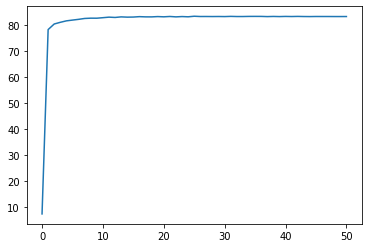

In [88]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

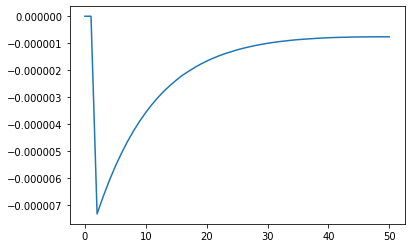

In [89]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

In [90]:

from torch.utils.data import DataLoader
import torch.nn



# select only the first 10 epochs

    

    
# choose a couple of dictionary keys
complete_data = []


for data_sets in [train_data, test_data, val_data]:
    data_list = []
    for data in data_sets:
        custom_data =  []
        custom_data.append(data['Train/val_accuracy'][0:10])
        #custom_data.append([data["config"]])
        


        data_list.append(custom_data)
        
    complete_data.append(data_list)
    
print(complete_data[0][1])
        



[[11.202998161315918, 48.087608337402344, 53.46297836303711, 43.72011947631836, 44.48249053955078, 45.03165817260742, 46.65331268310547, 49.52190017700195, 51.55704879760742, 53.92169570922852]]


In [91]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [92]:
from torch.utils.data import TensorDataset, DataLoader


#training_set = Dataset(complete_data[0], train_targets)
#test_set = Dataset(complete_data[1], test_targets)
#val_set = Dataset(complete_data[2], val_targets)

train_targets = torch.tensor(train_targets, dtype=torch.float, device=device)
test_targets = torch.tensor(test_targets, dtype=torch.float, device=device)
val_targets = torch.tensor(val_targets, dtype=torch.float, device=device)


training_set = TensorDataset(torch.FloatTensor(complete_data[0]), train_targets)
test_set = TensorDataset(torch.FloatTensor(complete_data[1]), test_targets)
val_set = TensorDataset(torch.FloatTensor(complete_data[2]), val_targets)



train_data_loader = DataLoader(dataset = training_set, batch_size = 32)
test_data_loader = DataLoader(dataset = test_set, batch_size = 32)
val_data_loader = DataLoader(dataset = val_set, batch_size = 32)




In [93]:
class LSTM_Net(torch.nn.Module):
    
    def __init__(self, input_size, num_classes, embedding_dim, hidden_size, seq_length, 
                 num_layers, bidirectional = False, drop_prob=0.5):
        super(LSTM_Net, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        
        # self.forecaster = torch.nn.Embedding(100, embedding_dim)

        self.dropout = torch.nn.Dropout(drop_prob)
        self.lstm = torch.nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_dim, 
                            num_layers = self.num_layers, dropout =drop_prob, bidirectional = bidirectional)
        
 
        
        self.linear1 = torch.nn.Linear(self.hidden_dim, num_classes)
        self.linear2 = torch.nn.Linear(self.hidden_dim, num_classes)
        self.linear3 = torch.nn.Linear(self.hidden_dim, num_classes)

        
        self.linear = torch.nn.Linear(self.hidden_dim, num_classes)
        
    
    
    def forward(self, x, hidden):
        
        batch_size = x.size(0)

        x = x.float()
            
        #print((x.size()))
        
        #forecast = self.forecaster(x)

        x = np.swapaxes(x,0,1)

        lstm_x, hidden = self.lstm(x, hidden)
        
        lstm_x = lstm_x.contiguous().view(-1, self.hidden_dim)

        x = self.dropout(lstm_x)
        
        x = self.linear(x)

        x = x.view(batch_size, -1)

        x = x[:,-1]
        

        return x, hidden
    
    def init_hidden(self, batch_size = 32):
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    

In [94]:
input_size = 10
outcome_dim = 1
embedding_dim = 400
hidden_dim = 50
seq_length = 1
num_layers = 3


model = LSTM_Net(input_size, outcome_dim, embedding_dim, hidden_dim, seq_length, num_layers)
model.to(device)

lr=0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [95]:
epochs = 1000
counter = 0
print_every = 32

clip = 5
valid_loss_min = np.Inf


model.train()

for i in range(epochs):
    
    
    for batches, labels in train_data_loader:
        counter += 1
        
        batch_size_calc = len(labels)
        hidden = model.init_hidden(batch_size=batch_size_calc)
    
        

        hidden = tuple([e.data for e in hidden])
        
        model.zero_grad()
        
        output, hidden = model(batches, hidden)
        
        
        loss = abs(criterion(output.squeeze(), labels.float()))
        loss.backward()
        
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    
        if counter%print_every == 0:
            
            val_losses = []
            model.eval()
            
            for inp, lab in val_data_loader:
                
                batch_size_calc = len(lab)

                val_h = model.init_hidden(batch_size = batch_size_calc)

                
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = abs(criterion(out.squeeze(), lab.float()))
                val_losses.append(val_loss.item())
                
                print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
                
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), '/home/sven/LCBench/state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
            




Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6184.987305
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6325.366699
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6350.398763
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6336.203857
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6307.235840
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6272.949300
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6304.253627
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6301.783447
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6326.162164
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6308.883105
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6294.634411
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6301.865397
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6312.667218
Epoch: 1/1000... Step: 32... Loss: 6077.204590... Val Loss: 6303

Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4240.375000
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4354.227539
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4376.358236
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4363.942505
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4340.877344
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4315.423014
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4340.663504
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4338.199951
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4357.904297
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4344.083008
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4332.874379
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4339.116455
Epoch: 8/1000... Step: 256... Loss: 4157.788574... Val Loss: 4347.726600
Epoch: 8/1000... Step: 256... Loss: 4157.788574... 

Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3117.505127
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3213.105469
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3233.243734
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3222.049438
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3203.049561
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3183.669596
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3204.737688
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3202.281158
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3218.769151
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3207.328931
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3198.212802
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3203.774516
Epoch: 15/1000... Step: 480... Loss: 3048.136475... Val Loss: 3210.876897
Epoch: 15/1000... Step: 480... Loss: 3

Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2199.147705
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2277.123901
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2295.338460
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2285.323547
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2270.248828
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2256.734334
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2273.773612
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2271.323883
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2284.706136
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2275.565039
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2268.469482
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2273.374207
Epoch: 22/1000... Step: 704... Loss: 2142.810547... Val Loss: 2279.020714
Epoch: 22/1000... Step: 704... Loss: 2

Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1452.213867
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1512.787415
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1529.102295
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1520.251892
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1509.053125
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1501.330363
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1514.391532
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1511.948486
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1522.264025
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1515.393188
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1510.292847
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1514.548838
Epoch: 29/1000... Step: 928... Loss: 1408.800537... Val Loss: 1518.757737
Epoch: 29/1000... Step: 928... Loss: 1

Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 867.332642
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 910.612030
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 925.039124
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 917.346024
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 909.998889
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 908.031759
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 917.139648
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 914.703239
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 921.971225
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 917.356476
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 914.238897
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 917.850204
Epoch: 36/1000... Step: 1152... Loss: 836.783386... Val Loss: 920.630493
Epoch: 36/1000... Step: 1152... Loss: 836.783386...

Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 440.607941
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 466.655640
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 479.201752
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 472.661743
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 469.152417
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 472.920166
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 478.089011
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 475.659214
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 479.890628
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 477.523828
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 476.381866
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 479.350812
Epoch: 43/1000... Step: 1376... Loss: 422.885162... Val Loss: 480.707628
Epoch: 43/1000... Step: 1376... Loss: 422.885162...

Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 170.089035
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 178.944626
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 189.613897
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 184.224468
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 184.544080
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 194.033333
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 195.272204
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 192.849110
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 194.050930
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 193.926855
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 194.755877
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 197.083899
Epoch: 50/1000... Step: 1600... Loss: 165.168976... Val Loss: 197.020612
Epoch: 50/1000... Step: 1600... Loss: 165.168976...

Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 46.564339
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 50.769115
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 56.253118
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 52.875123
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 53.394943
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 51.837417
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 52.334042
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 51.986085
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 52.850482
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 53.520275
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 53.504884
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 55.374404
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 56.196272
Epoch: 57/1000... Step: 1824... Loss: 68.129448... Val Loss: 56.860626
Epoch:

Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 21.485376
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 22.549453
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 25.807210
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 23.823348
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 24.871218
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 24.103345
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 23.728960
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 23.458899
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 23.656759
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 24.127360
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 24.157078
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 25.740319
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 26.224074
Epoch: 64/1000... Step: 2048... Loss: 52.555939... Val Loss: 27.115482
Epoch:

Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 14.177811
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 13.589571
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 15.360492
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 14.751396
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 15.298413
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 15.418476
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 15.140484
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 14.975950
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 15.053904
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 15.870684
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 16.244459
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 17.164985
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 17.781756
Epoch: 71/1000... Step: 2272... Loss: 42.617912... Val Loss: 18.084889
Epoch:

Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 11.378613
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 10.297481
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 12.060430
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 11.727375
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 12.738504
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 12.767508
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 11.903075
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 11.311563
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 11.220529
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 11.542669
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 11.636497
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 12.798031
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 13.106122
Epoch: 79/1000... Step: 2528... Loss: 44.395473... Val Loss: 13.843995
Epoch:

Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 11.069336
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 9.466470
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 10.938828
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 10.912420
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 11.776676
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 12.017489
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 11.053114
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 10.436769
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 10.287263
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 10.585313
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 10.717424
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 11.582790
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 11.855213
Epoch: 86/1000... Step: 2752... Loss: 40.723263... Val Loss: 12.501637
Epoch: 

Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 12.477000
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 9.909484
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 11.199385
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 11.353187
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 12.213154
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 12.381500
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 11.332588
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 10.743640
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 10.525610
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 10.675370
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 10.740729
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 11.591343
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 11.755366
Epoch: 94/1000... Step: 3008... Loss: 35.929478... Val Loss: 12.311021
Epoch: 

Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 11.530201
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 9.279280
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 10.270989
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 10.631548
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 11.682289
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 11.525012
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 10.512216
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 9.989461
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 9.785719
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 9.764575
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 9.925402
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 10.723402
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 10.947478
Epoch: 102/1000... Step: 3264... Loss: 34.775780... Val Loss: 11.5278

Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 11.262446
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 9.350401
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 10.373761
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 10.276260
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 11.468551
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 11.190610
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 10.111669
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 9.495526
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 9.203838
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 9.120669
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 9.288124
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 10.181907
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 10.403778
Epoch: 110/1000... Step: 3520... Loss: 31.645990... Val Loss: 11.1373

Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 9.713120
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 8.329367
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 9.887081
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 9.045474
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 9.910118
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 9.668542
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 8.782252
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 8.268954
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 8.128159
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 8.080436
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 8.207082
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 9.083522
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 9.408392
Epoch: 118/1000... Step: 3776... Loss: 15.838518... Val Loss: 10.017702
Epoch

Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 10.366731
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 8.635685
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 9.719696
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 9.225833
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 10.321929
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 10.011628
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 9.023628
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 8.432458
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 8.192689
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 8.086563
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 8.227387
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 9.052021
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 9.345749
Epoch: 126/1000... Step: 4032... Loss: 20.528206... Val Loss: 10.049856
Ep

Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 8.766268
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 7.538620
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 8.999665
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 8.043726
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 8.983383
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 8.886013
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 8.127468
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 7.687793
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 7.654534
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 7.774884
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 7.933736
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 8.659687
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 9.012424
Epoch: 134/1000... Step: 4288... Loss: 16.153807... Val Loss: 9.638353
Epoch:

Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 8.935721
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 7.605284
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 9.051002
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 8.261157
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 9.267681
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 9.135533
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 8.320120
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 7.856659
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 7.751026
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 7.706725
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 7.841588
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 8.587957
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 8.878123
Epoch: 141/1000... Step: 4512... Loss: 11.413824... Val Loss: 9.468853
Epoch:

Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 9.406488
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 7.892499
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 9.303916
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 8.503726
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 9.685078
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 9.578039
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 8.705489
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 8.118868
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 7.968849
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 8.015859
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 8.113977
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 8.914611
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 9.153004
Epoch: 149/1000... Step: 4768... Loss: 18.088945... Val Loss: 9.817216
Epoch:

Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 8.841402
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 7.520612
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 8.903582
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 8.093042
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 9.093987
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 8.960275
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 8.158890
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 7.771441
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 7.633530
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 7.606622
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 7.717530
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 8.405381
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 8.709013
Epoch: 157/1000... Step: 5024... Loss: 8.337795... Val Loss: 9.295255
Epoch: 157/1000... S

Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 11.274365
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 9.182651
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 9.997449
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 9.738625
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 10.842537
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 10.717291
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 9.661208
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 8.956018
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 8.679483
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 8.654709
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 8.815784
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 9.536777
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 9.737193
Epoch: 165/1000... Step: 5280... Loss: 24.901190... Val Loss: 10.474093
Ep

Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 11.081587
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 9.039715
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 9.782228
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 9.565907
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 10.678931
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 10.621058
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 9.582782
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 8.891731
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 8.633330
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 8.623761
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 8.805267
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 9.499596
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 9.699850
Epoch: 173/1000... Step: 5536... Loss: 24.147573... Val Loss: 10.422815
Ep

Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 11.546029
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 9.312161
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 10.010649
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 9.820204
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 10.891832
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 10.793693
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 9.757749
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 9.071677
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 8.808471
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 8.707803
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 8.908292
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 9.598930
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 9.790481
Epoch: 181/1000... Step: 5792... Loss: 18.718559... Val Loss: 10.475895
E

Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 10.080748
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 8.439371
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 9.437115
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 8.532325
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 9.578312
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 9.421231
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 8.547818
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 7.989325
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 7.775968
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 7.734115
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 7.858323
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 8.532304
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 8.801656
Epoch: 189/1000... Step: 6048... Loss: 14.167773... Val Loss: 9.517092
Epoch

Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 9.363899
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 7.814742
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 9.158489
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 8.203954
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 9.336327
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 9.149411
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 8.316659
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 7.866809
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 7.672008
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 7.573332
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 7.623824
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 8.405318
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 8.648896
Epoch: 197/1000... Step: 6304... Loss: 8.628401... Val Loss: 9.269378
Epoch: 197/1000... S

Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 9.675793
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 7.867896
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 8.948448
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 8.178038
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 9.079021
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 8.928631
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 8.134938
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 7.795432
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 7.626841
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 7.610017
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 7.701383
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 8.289426
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 8.559241
Epoch: 205/1000... Step: 6560... Loss: 7.769568... Val Loss: 9.129633
Epoch: 205/1000... S

Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 10.526687
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 8.468542
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 9.844351
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 8.917824
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 10.051901
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 9.884838
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 8.892264
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 8.279832
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 8.031894
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 7.968202
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 8.024631
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 8.861566
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 9.074384
Epoch: 213/1000... Step: 6816... Loss: 9.399905... Val Loss: 9.757101
Epoch: 213/1000...

Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 9.624026
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 7.882764
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 8.949373
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 8.001848
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 8.811638
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 8.771068
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 7.981590
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 7.675918
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 7.513478
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 7.514441
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 7.623753
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 8.200147
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 8.483238
Epoch: 221/1000... Step: 7072... Loss: 6.951799... Val Loss: 9.056746
Epoch: 221/1000... S

Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 9.635393
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 7.973262
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 8.901539
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 8.218047
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 9.141678
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 8.953331
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 8.158511
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 7.934840
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 7.743231
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 7.668741
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 7.743935
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 8.350192
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 8.607673
Epoch: 229/1000... Step: 7328... Loss: 6.673092... Val Loss: 9.121002
Epoch: 229/1000... S

Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 9.662741
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 8.037793
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 8.816699
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 8.091676
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 9.047367
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 8.888375
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 8.120239
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 7.848522
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 7.676285
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 7.620535
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 7.737484
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 8.294283
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 8.549574
Epoch: 237/1000... Step: 7584... Loss: 6.674721... Val Loss: 9.074002
Epoch: 237/1000... S

Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 10.471430
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 8.479626
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 9.424260
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 8.752426
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 9.865145
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 9.708252
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 8.780682
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 8.262681
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 8.056370
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 7.955708
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 8.021790
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 8.725617
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 8.930684
Epoch: 245/1000... Step: 7840... Loss: 8.369362... Val Loss: 9.537378
Epoch: 245/1000... 

Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 10.372189
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 8.399569
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 9.176562
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 8.944825
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 9.975031
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 9.838521
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 8.910629
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 8.460449
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 8.301441
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 8.165509
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 8.327846
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 8.902833
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 9.134032
Epoch: 253/1000... Step: 8096... Loss: 6.967514... Val Loss: 9.661520
Epoch: 253/1000... 

Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 11.242660
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 8.993374
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 9.703902
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 9.077803
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 10.133758
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 10.194949
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 9.185402
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 8.549988
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 8.353960
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 8.308134
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 8.421141
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 9.048452
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 9.261179
Epoch: 261/1000... Step: 8352... Loss: 8.462616... Val Loss: 9.972770
Epoch: 261/1000..

Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 11.030662
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 9.362413
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 9.522553
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 9.140024
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 10.230750
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 10.135989
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 9.245661
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 8.747021
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 8.535011
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 8.378985
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 8.560824
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 9.121015
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 9.291750
Epoch: 269/1000... Step: 8608... Loss: 8.202366... Val Loss: 9.828819
Epoch: 269/1000..

Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 11.788600
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 10.111888
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 10.039187
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 9.633628
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 10.695541
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 10.635055
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 9.706011
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 9.208446
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 8.979302
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 8.800488
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 8.959016
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 9.487454
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 9.639951
Epoch: 277/1000... Step: 8864... Loss: 7.890692... Val Loss: 10.192491
Epoch: 277/100

Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 11.221755
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 10.356756
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 9.930270
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 9.487281
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 10.666828
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 10.739998
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 9.832507
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 9.389651
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 9.155051
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 8.988074
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 9.177464
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 9.643589
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 9.795196
Epoch: 285/1000... Step: 9120... Loss: 7.725259... Val Loss: 10.313717
Epoch: 285/1000

Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 10.724685
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 10.921286
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 10.398711
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 9.522373
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 10.816209
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 10.724153
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 9.659898
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 9.109586
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 8.809026
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 8.652995
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 8.671525
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 9.323762
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 9.475100
Epoch: 293/1000... Step: 9376... Loss: 10.054910... Val Loss: 10.086532


Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 11.467264
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 10.992009
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 10.221189
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 9.784723
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 10.861868
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 10.807422
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 9.878124
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 9.444737
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 9.223772
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 9.008845
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 9.170741
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 9.585809
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 9.726767
Epoch: 301/1000... Step: 9632... Loss: 5.224190... Val Loss: 10.186034
Epoch: 301/100

Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 10.749331
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 11.725408
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 10.642546
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 9.808933
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 11.028429
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 10.924152
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 9.901201
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 9.406155
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 9.101172
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 8.866087
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 8.888007
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 9.458015
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 9.573920
Epoch: 309/1000... Step: 9888... Loss: 9.163854... Val Loss: 10.070254
Epoch: 309/100

Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 10.639927
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 9.938881
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 9.988661
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 8.921822
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 10.398841
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 10.115382
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 9.094854
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 8.609939
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 8.336755
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 8.145299
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 8.097101
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 8.870084
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 9.038646
Epoch: 317/1000... Step: 10144... Loss: 7.231367... Val Loss: 9.629801
Epo

Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 11.977663
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 11.049150
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 10.271822
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 9.893922
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 11.122571
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 11.104161
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 10.129832
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 9.519813
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 9.288046
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 9.092353
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 9.276706
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 9.684865
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 9.816413
Epoch: 325/1000... Step: 10400... Loss: 7.074653... Val Loss: 10.383359

Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 11.874277
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 13.054760
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 11.472733
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 11.010307
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 12.261718
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 12.053156
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 11.048389
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 10.466294
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 10.135248
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 9.772207
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 9.915851
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 10.327990
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 10.378764
Epoch: 333/1000... Step: 10656... Loss: 7.562973... Val Loss: 10.8

Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 9.234338
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 15.520877
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 12.929256
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 11.399725
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 12.286293
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 11.691421
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 10.576125
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 10.033414
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 9.547345
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 9.092864
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 9.002810
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 9.438723
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 9.414842
Epoch: 341/1000... Step: 10912... Loss: 5.958553... Val Loss: 9.695829

Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 11.444767
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 18.537332
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 15.029131
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 13.405422
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 13.972798
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 13.501761
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 12.259184
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 11.741150
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 11.248148
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 10.719717
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 10.587862
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 10.962342
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 10.895793
Epoch: 349/1000... Step: 11168... Loss: 2.949079... Val Loss: 11

Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 8.782090
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 18.671025
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 15.078831
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 13.084951
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 13.612228
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 12.726381
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 11.494601
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 11.060257
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 10.461985
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 9.925324
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 9.759997
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 9.971543
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 9.914928
Epoch: 357/1000... Step: 11424... Loss: 3.668766... Val Loss: 10.0611

Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 11.388441
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 19.899563
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 16.058087
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 14.421851
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 14.879491
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 14.231353
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 12.958847
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 12.335394
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 11.710061
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 11.096194
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 10.987793
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 11.221349
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 11.060842
Epoch: 365/1000... Step: 11680... Loss: 4.889412... Val Loss: 11

Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 10.199771
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 19.128044
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 15.552553
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 13.408915
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 13.724474
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 12.906053
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 11.612168
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 11.028868
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 10.461330
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 9.947319
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 9.753389
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 10.133063
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 10.035006
Epoch: 373/1000... Step: 11936... Loss: 3.337965... Val Loss: 10.2

Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 9.750513
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 18.074783
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 14.768229
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 12.932666
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 13.560388
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 12.899571
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 11.612685
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 10.991787
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 10.436898
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 9.899186
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 9.759626
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 10.067328
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 9.967592
Epoch: 381/1000... Step: 12192... Loss: 4.258037... Val Loss: 10.233

Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 11.345659
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 20.187545
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 16.266086
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 14.429249
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 14.935871
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 14.310374
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 12.986668
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 12.342926
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 11.767303
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 11.144442
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 11.038718
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 11.245682
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 11.099234
Epoch: 389/1000... Step: 12448... Loss: 3.039910... Val Loss: 11

Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 9.183768
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 22.940969
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 17.831293
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 15.186687
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 15.435167
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 14.141817
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 12.750402
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 12.091456
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 11.267238
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 10.580149
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 10.294372
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 10.510191
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 10.255439
Epoch: 397/1000... Step: 12704... Loss: 4.836452... Val Loss: 10.

Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 9.865923
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 22.082808
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 17.385743
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 15.024151
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 15.233247
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 14.133909
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 12.748337
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 12.202371
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 11.543410
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 10.889056
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 10.680854
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 10.744880
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 10.622089
Epoch: 405/1000... Step: 12960... Loss: 2.819411... Val Loss: 10.

Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 8.250771
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 22.095070
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 17.313533
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 14.570754
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 14.857149
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 13.452210
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 12.047807
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 11.489370
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 10.737114
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 10.091555
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 9.777920
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 9.920615
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 9.777643
Epoch: 413/1000... Step: 13216... Loss: 3.203022... Val Loss: 9.8785

Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 10.539902
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 19.589670
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 15.825636
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 13.823358
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 14.290588
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 13.601339
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 12.289867
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 11.636553
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 11.048579
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 10.450060
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 10.305057
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 10.462618
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 10.320548
Epoch: 421/1000... Step: 13472... Loss: 3.479615... Val Loss: 10

Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 8.875736
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 24.157650
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 18.610833
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 15.875193
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 15.828799
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 14.512320
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 13.063190
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 12.723318
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 11.947860
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 11.232638
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 10.920269
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 10.962151
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 10.751650
Epoch: 429/1000... Step: 13728... Loss: 2.688434... Val Loss: 10.

Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 9.932824
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 21.917994
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 17.144367
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 14.943714
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 15.321309
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 14.328426
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 12.958056
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 12.228194
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 11.553444
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 10.875266
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 10.712520
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 10.912097
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 10.691887
Epoch: 437/1000... Step: 13984... Loss: 3.934348... Val Loss: 10.

Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 8.490941
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 24.568694
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 18.754869
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 15.883322
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 15.922556
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 14.276508
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 12.779075
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 12.379759
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 11.572263
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 10.808252
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 10.409502
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 10.642669
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 10.399968
Epoch: 445/1000... Step: 14240... Loss: 2.966755... Val Loss: 10.

Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 10.511240
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 23.473262
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 18.164301
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 15.862522
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 16.033948
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 15.036853
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 13.645530
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 13.040462
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 12.296099
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 11.540472
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 11.335495
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 11.560063
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 11.295281
Epoch: 453/1000... Step: 14496... Loss: 3.871163... Val Loss: 11

Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 10.615484
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 20.870683
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 16.451164
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 14.556539
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 14.902450
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 14.051593
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 12.743347
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 12.163022
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 11.539212
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 10.875875
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 10.746951
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 10.885517
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 10.709013
Epoch: 461/1000... Step: 14752... Loss: 2.932769... Val Loss: 10

Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 8.557214
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 20.826277
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 16.246391
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 13.898723
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 14.318702
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 12.911144
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 11.540437
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 10.972825
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 10.196099
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 9.556413
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 9.273740
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 9.540347
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 9.325734
Epoch: 469/1000... Step: 15008... Loss: 4.984231... Val Loss: 9.49920

Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 9.468563
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 18.734427
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 14.963791
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 13.202225
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 13.707009
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 12.876505
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 11.660249
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 11.136596
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 10.542115
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 9.968400
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 9.843728
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 9.989287
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 9.821469
Epoch: 477/1000... Step: 15264... Loss: 3.673259... Val Loss: 10.0819

Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 10.259396
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 19.488305
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 15.924726
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 14.144926
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 14.539382
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 13.703689
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 12.476322
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 12.124423
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 11.530537
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 10.972353
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 10.861655
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 10.715728
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 10.629650
Epoch: 485/1000... Step: 15520... Loss: 3.329533... Val Loss: 10

Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 8.660512
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 18.238024
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 14.440769
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 12.727525
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 13.379692
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 12.562015
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 11.348571
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 10.764769
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 10.196447
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 9.646245
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 9.528610
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 10.007209
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 9.833528
Epoch: 493/1000... Step: 15776... Loss: 3.608602... Val Loss: 10.095

Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 9.615649
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 17.517992
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 14.397058
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 12.632686
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 13.501990
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 12.775365
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 11.524367
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 10.812117
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 10.230279
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 9.699469
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 9.577241
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 9.822470
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 9.641239
Epoch: 501/1000... Step: 16032... Loss: 4.913225... Val Loss: 10.0359

Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 9.649570
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 18.019193
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 14.721422
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 12.540076
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 13.217382
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 12.296803
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 11.005213
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 10.352546
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 9.750857
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 9.278452
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 9.059721
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 9.270885
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 9.133976
Epoch: 509/1000... Step: 16288... Loss: 4.231841... Val Loss: 9.525555

Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 10.749780
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 16.499926
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 13.951109
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 12.207434
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 13.072290
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 12.416474
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 11.134187
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 10.411230
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 9.857365
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 9.542116
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 9.351632
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 9.652094
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 9.544669
Epoch: 517/1000... Step: 16544... Loss: 7.711607... Val Loss: 10.0694

Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 10.191587
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 19.171204
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 15.364489
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 13.524423
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 14.206362
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 13.248829
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 11.992971
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 11.448779
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 10.796862
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 10.170102
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 10.029256
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 10.234574
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 10.064413
Epoch: 525/1000... Step: 16800... Loss: 4.233020... Val Loss: 10

Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 7.682240
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 19.272420
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 15.012640
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 12.904584
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 13.384939
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 11.857451
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 10.605828
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 10.283011
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 9.574524
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 8.984655
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 8.642967
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 8.777422
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 8.676564
Epoch: 533/1000... Step: 17056... Loss: 3.139723... Val Loss: 8.812996

Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 8.106804
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 17.462543
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 13.775237
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 11.888257
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 12.536946
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 11.289004
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 10.071269
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 9.701568
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 9.051710
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 8.484840
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 8.226369
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 8.443476
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 8.348516
Epoch: 541/1000... Step: 17312... Loss: 3.786192... Val Loss: 8.586530


Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 9.326515
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 16.371273
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 13.996461
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 12.407427
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 13.063839
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 12.251733
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 11.229342
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 10.695994
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 10.230656
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 9.747590
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 9.691685
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 9.596246
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 9.604335
Epoch: 549/1000... Step: 17568... Loss: 4.411329... Val Loss: 9.86864

Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 8.683042
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 19.169797
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 14.979657
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 13.181173
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 13.704872
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 12.483528
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 11.293150
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 11.143414
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 10.511525
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 9.813253
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 9.557954
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 9.760774
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 9.685351
Epoch: 557/1000... Step: 17824... Loss: 3.289255... Val Loss: 9.78830

Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 8.795737
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 16.159829
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 13.398277
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 11.729871
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 12.454303
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 11.429765
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 10.303738
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 9.910110
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 9.295083
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 8.786079
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 8.620323
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 8.637674
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 8.547236
Epoch: 565/1000... Step: 18080... Loss: 4.149591... Val Loss: 8.846918


Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 6.349558
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 15.933717
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 13.080319
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 11.362994
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 12.470130
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 11.010363
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 9.853544
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 9.506301
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 8.888791
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 8.311011
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 8.081095
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 8.172219
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 8.159712
Epoch: 573/1000... Step: 18336... Loss: 2.214665... Val Loss: 8.322775
E

Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 14.539132
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 20.457370
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 17.064926
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 16.168081
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 16.794140
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 16.400632
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 15.397305
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 14.980260
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 14.486698
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 13.837774
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 13.913451
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 13.729425
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 13.528824
Epoch: 581/1000... Step: 18592... Loss: 7.351013... Val Loss: 13

Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 8.490903
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 14.775439
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 12.581569
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 11.242905
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 11.935169
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 11.110287
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 10.092026
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 9.707983
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 9.225985
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 8.766491
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 8.655277
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 8.617099
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 8.572405
Epoch: 589/1000... Step: 18848... Loss: 3.656291... Val Loss: 8.874462


Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 7.928806
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 14.240547
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 11.854490
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 10.706250
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 11.837267
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 11.068919
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 10.014441
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 9.480347
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 9.033068
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 8.593841
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 8.540396
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 8.592705
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 8.535401
Epoch: 597/1000... Step: 19104... Loss: 4.597963... Val Loss: 8.895569


Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 7.464688
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 15.140804
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 12.213474
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 10.497853
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 11.532406
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 10.300514
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 9.118838
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 8.652993
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 8.046095
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 7.553980
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 7.315591
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 7.719239
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 7.663864
Epoch: 605/1000... Step: 19360... Loss: 5.028015... Val Loss: 8.007358
E

Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 6.842572
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 16.861037
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 13.808964
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 12.006053
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 12.837431
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 11.245894
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 10.149915
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 9.981106
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 9.333388
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 8.713270
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 8.415949
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 8.653096
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 8.806628
Epoch: 613/1000... Step: 19616... Loss: 1.865520... Val Loss: 8.915137


Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 9.269992
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 16.520888
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 13.539653
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 12.422659
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 13.122018
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 12.222441
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 11.257675
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 11.046352
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 10.524700
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 9.986298
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 9.952035
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 9.833970
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 9.799429
Epoch: 621/1000... Step: 19872... Loss: 3.668048... Val Loss: 9.97263

Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 6.842441
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 12.740310
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 10.808386
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 9.654283
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 10.828968
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 9.869881
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 8.894864
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 8.454328
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 7.952571
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 7.490901
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 7.429501
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 7.695808
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 7.598141
Epoch: 629/1000... Step: 20128... Loss: 3.824998... Val Loss: 7.886376
Epo

Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 6.357612
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 13.913640
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 11.524662
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 10.049025
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 11.073875
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 9.787743
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 8.741513
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 8.395475
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 7.848759
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 7.333660
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 7.144327
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 7.291310
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 7.335563
Epoch: 637/1000... Step: 20384... Loss: 2.432413... Val Loss: 7.549273
Ep

Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 8.453229
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 14.156662
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 11.600536
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 10.283602
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 11.263227
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 10.290908
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 9.315388
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 8.926957
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 8.472507
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 7.937881
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 7.799747
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 8.132400
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 8.138763
Epoch: 645/1000... Step: 20640... Loss: 1.538084... Val Loss: 8.393043
E

Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 7.640047
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 14.673584
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 11.830088
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 10.304616
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 11.403789
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 10.119354
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 9.039588
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 8.630167
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 8.045355
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 7.505088
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 7.279943
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 7.671432
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 7.656374
Epoch: 653/1000... Step: 20896... Loss: 3.477980... Val Loss: 7.891984
E

Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 10.880840
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 14.372723
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 12.095504
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 11.295595
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 12.719594
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 12.286574
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 11.370255
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 10.893242
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 10.537132
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 10.018930
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 10.045996
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 10.338419
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 10.294149
Epoch: 661/1000... Step: 21152... Loss: 3.603355... Val Loss: 10

Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 9.793714
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 14.604830
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 12.171190
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 11.194829
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 12.459477
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 11.665916
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 10.749669
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 10.272174
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 9.753568
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 9.203949
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 9.181752
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 9.405108
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 9.285628
Epoch: 669/1000... Step: 21408... Loss: 4.847063... Val Loss: 9.637269

Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 8.117482
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 13.298901
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 10.998785
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 9.933966
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 11.067800
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 9.922143
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 8.894783
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 8.515846
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 7.973224
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 7.531684
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 7.341857
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 7.596203
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 7.462634
Epoch: 677/1000... Step: 21664... Loss: 4.792032... Val Loss: 7.749649
Epo

Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 6.849936
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 13.536524
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 11.910735
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 10.497397
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 11.668686
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 10.459953
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 9.455575
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 9.178104
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 8.778240
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 8.211686
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 7.980675
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 8.191034
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 8.419888
Epoch: 685/1000... Step: 21920... Loss: 1.755142... Val Loss: 8.550341
E

Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 6.075541
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 11.222173
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 10.327623
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 9.334277
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 10.427676
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 9.319428
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 8.516207
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 8.438157
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 8.103819
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 7.750117
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 7.647823
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 7.838321
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 8.170526
Epoch: 693/1000... Step: 22176... Loss: 0.737820... Val Loss: 8.313812
Epo

Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 12.539524
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 15.320121
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 13.461594
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 13.076967
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 13.895429
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 13.467682
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 12.693416
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 12.542325
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 12.171101
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 11.721326
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 11.836251
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 11.686220
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 11.508287
Epoch: 701/1000... Step: 22432... Loss: 6.825254... Val Loss: 11

Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 7.345212
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 12.542579
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 10.360086
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 9.245295
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 10.218820
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 9.027677
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 8.082981
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 7.883846
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 7.403108
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 6.958834
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 6.713457
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 7.056916
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 7.008877
Epoch: 709/1000... Step: 22688... Loss: 2.082783... Val Loss: 7.251729
Epo

Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 11.701571
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 15.316678
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 12.872826
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 12.255712
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 13.060906
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 12.716338
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 11.984612
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 11.897208
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 11.517256
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 10.939421
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 11.004429
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 11.085122
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 10.982742
Epoch: 717/1000... Step: 22944... Loss: 5.135436... Val Loss: 11

Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 6.569017
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 8.794855
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 8.301378
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 7.600990
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 9.080590
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 8.330159
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 7.464744
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 6.933254
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 6.758581
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 6.496729
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 6.478702
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 6.853317
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 6.851343
Epoch: 725/1000... Step: 23200... Loss: 3.923111... Val Loss: 7.248451
Epoch:

Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 6.842829
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 11.622034
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 9.841694
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 9.189643
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 10.368209
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 9.315551
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 8.415477
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 8.353958
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 7.834057
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 7.315987
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 7.230480
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 7.460075
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 7.353053
Epoch: 733/1000... Step: 23456... Loss: 2.565790... Val Loss: 7.582111
Epoc

Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 7.162209
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 10.756514
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 9.295928
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 8.317125
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 9.486195
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 8.488344
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 7.613087
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 7.486636
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 7.114191
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 6.700336
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 6.540806
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 6.892106
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 6.890432
Epoch: 741/1000... Step: 23712... Loss: 2.056823... Val Loss: 7.203641
Epoch

Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 8.267401
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 11.627845
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 10.114819
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 9.538843
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 10.982247
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 10.202689
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 9.369132
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 9.373357
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 8.872289
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 8.320284
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 8.319617
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 8.580718
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 8.411288
Epoch: 749/1000... Step: 23968... Loss: 6.138638... Val Loss: 8.640192
Ep

Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 7.843789
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 11.128383
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 9.496636
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 8.818084
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 10.312168
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 9.440009
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 8.601394
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 8.505090
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 8.067322
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 7.562632
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 7.566447
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 7.872317
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 7.739874
Epoch: 757/1000... Step: 24224... Loss: 4.366459... Val Loss: 7.898832
Epoc

Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 14.113582
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 15.250913
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 13.654159
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 13.145329
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 14.558546
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 14.408435
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 13.650127
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 13.558216
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 13.126795
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 12.564385
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 12.617631
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 12.705721
Epoch: 765/1000... Step: 24480... Loss: 12.548031... Val Loss: 12.347460
Epoch: 765/1000... Step: 24480... Loss: 12.548031..

Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 5.858067
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 10.525045
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 9.139990
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 8.364403
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 9.510771
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 8.379242
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 7.551370
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 7.491251
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 7.089045
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 6.583860
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 6.435720
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 6.748317
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 6.893018
Epoch: 773/1000... Step: 24736... Loss: 1.414886... Val Loss: 7.094473
Epoch

Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 10.063534
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 12.083940
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 10.866074
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 10.227516
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 11.307582
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 10.551353
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 9.859572
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 9.566073
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 9.146656
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 8.709600
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 8.681780
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 8.797012
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 8.651833
Epoch: 781/1000... Step: 24992... Loss: 8.332712... Val Loss: 8.949698


Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 6.573559
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 9.475654
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 8.886735
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 8.564607
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 9.745011
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 8.819972
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 8.071392
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 8.011769
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 7.655372
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 7.320255
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 7.349453
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 7.384663
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 7.401354
Epoch: 789/1000... Step: 25248... Loss: 2.463110... Val Loss: 7.582348
Epoch:

Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 6.028861
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 10.774390
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 9.596078
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 8.692585
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 10.428967
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 9.168060
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 8.104894
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 7.811319
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 7.284431
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 6.739884
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 6.559336
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 6.854658
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 6.821745
Epoch: 797/1000... Step: 25504... Loss: 3.563239... Val Loss: 7.092692
Epoc

Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 7.738776
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 9.542583
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 8.737608
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 8.174820
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 9.629222
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 8.855659
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 8.095021
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 7.853790
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 7.413734
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 7.031156
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 7.079206
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 7.176013
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 7.031593
Epoch: 805/1000... Step: 25760... Loss: 4.895915... Val Loss: 7.414734
Epoch:

Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 7.340745
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 9.768190
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 8.694372
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 7.867169
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 9.552583
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 8.601528
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 7.785403
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 7.622728
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 7.181629
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 6.711301
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 6.590446
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 6.705282
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 6.552688
Epoch: 813/1000... Step: 26016... Loss: 7.827389... Val Loss: 6.753315
Epoch:

Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 7.005669
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 8.895012
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 8.026457
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 7.507129
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 9.150877
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 8.317528
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 7.546954
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 7.279598
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 6.861133
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 6.446660
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 6.464083
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 6.641407
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 6.529845
Epoch: 821/1000... Step: 26272... Loss: 3.931151... Val Loss: 6.939313
Epoch:

Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 6.834566
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 9.068188
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 8.402464
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 7.754097
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 9.208592
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 8.202620
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 7.465292
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 7.563916
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 7.169475
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 6.703781
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 6.617946
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 6.716399
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 6.669298
Epoch: 829/1000... Step: 26528... Loss: 3.526489... Val Loss: 6.806302
Epoch:

Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 7.197532
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 10.996648
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 10.298779
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 9.662077
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 11.276488
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 10.176536
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 9.363482
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 9.423535
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 9.081929
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 8.504647
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 8.300084
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 8.755793
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 8.864904
Epoch: 837/1000... Step: 26784... Loss: 2.566607... Val Loss: 8.954367
Ep

Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 7.021215
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 8.255752
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 7.612657
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 7.034522
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 8.541763
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 7.914112
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 7.117141
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 6.883236
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 6.661890
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 6.297612
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 6.269818
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 6.439503
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 6.488999
Epoch: 845/1000... Step: 27040... Loss: 2.893263... Val Loss: 6.919392
Epoch:

Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 13.211244
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 12.996033
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 12.111262
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 11.312247
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 13.384098
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 12.603441
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 11.606506
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 11.173805
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 10.726198
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 10.370101
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 10.348019
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 10.493374
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 10.300823
Epoch: 853/1000... Step: 27296... Loss: 7.648436... Val Loss: 10

Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 12.515054
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 13.397798
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 11.993897
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 11.932289
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 13.507772
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 13.154824
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 12.498905
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 12.297855
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 11.998162
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 11.498469
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 11.756817
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 11.806131
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 11.523524
Epoch: 861/1000... Step: 27552... Loss: 9.362366... Val Loss: 11

Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 6.668330
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 8.982760
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 8.519552
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 7.689767
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 9.435890
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 8.466922
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 7.674590
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 7.496236
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 7.269934
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 6.851286
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 6.689589
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 7.099293
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 7.218071
Epoch: 869/1000... Step: 27808... Loss: 5.351039... Val Loss: 7.510775
Epoch:

Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 7.655632
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 8.529396
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 7.789977
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 7.426627
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 8.717514
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 7.821358
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 7.079546
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 6.965796
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 6.622855
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 6.218230
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 6.176781
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 6.395399
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 6.352580
Epoch: 877/1000... Step: 28064... Loss: 4.183733... Val Loss: 6.562073
Epoch:

Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 6.621939
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 9.201761
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 8.057852
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 7.695338
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 9.121646
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 8.101523
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 7.198962
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 7.194310
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 6.752982
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 6.251173
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 6.167704
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 6.759377
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 6.719284
Epoch: 885/1000... Step: 28320... Loss: 4.170168... Val Loss: 6.967493
Epoch:

Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 7.627068
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 8.572544
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 7.670690
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 7.246539
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 8.783501
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 7.938739
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 7.231327
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 7.163028
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 6.806322
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 6.430084
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 6.375644
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 6.484156
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 6.354722
Epoch: 893/1000... Step: 28576... Loss: 3.209108... Val Loss: 6.644651
Epoch:

Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 6.353184
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 7.911110
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 7.618090
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 6.897406
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 8.232566
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 7.389129
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 6.707138
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 6.509521
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 6.228473
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 5.886007
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 5.849685
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 6.131787
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 6.270777
Epoch: 901/1000... Step: 28832... Loss: 3.348532... Val Loss: 6.524975
Epoch:

Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 6.535900
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 8.276070
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 7.698060
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 6.951124
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 8.624388
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 7.719377
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 6.953391
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 6.615236
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 6.177956
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 5.795448
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 5.787300
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 5.858159
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 5.771144
Epoch: 909/1000... Step: 29088... Loss: 4.187616... Val Loss: 6.130421
Epoch:

Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 11.053649
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 12.007822
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10.504711
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10.481088
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 12.222576
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 11.678569
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 11.024218
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10.966422
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10.606673
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10.090579
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10.256934
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10.458756
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10.222422
Epoch: 917/1000... Step: 29344... Loss: 4.625359... Val Loss: 10

Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 5.507032
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 8.088054
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 7.553734
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 7.280056
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 8.746627
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 7.720112
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 6.988952
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 6.963129
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 6.552999
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 6.215589
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 6.217488
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 6.486365
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 6.581607
Epoch: 925/1000... Step: 29600... Loss: 2.949847... Val Loss: 6.782214
Epoch:

Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 8.106138
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 9.224821
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 8.154683
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.922658
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 9.275470
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 8.545122
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.795079
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.715104
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.396967
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.014099
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.034335
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.415844
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.266684
Epoch: 933/1000... Step: 29856... Loss: 7.039532... Val Loss: 7.602917
Epoch:

Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 8.770325
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 9.212474
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 8.216670
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 7.875390
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 9.746892
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 9.072095
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 8.382676
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 8.037880
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 7.695483
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 7.339289
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 7.433408
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 7.786794
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 7.655089
Epoch: 941/1000... Step: 30112... Loss: 7.087331... Val Loss: 8.105899
Epoch:

Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.642568
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 9.326633
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.112878
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.187599
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 9.788284
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 9.055578
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.521452
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.549899
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.199527
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 7.801468
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 7.956473
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.458196
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.286966
Epoch: 949/1000... Step: 30368... Loss: 6.323939... Val Loss: 8.576710
Epoch:

Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 7.771050
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 8.294744
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 7.364854
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 6.882861
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 8.873251
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 7.923638
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 7.027559
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 6.718406
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 6.339138
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 5.988742
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 5.901774
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 6.296760
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 6.265059
Epoch: 957/1000... Step: 30624... Loss: 5.012537... Val Loss: 6.648096
Epoch:

Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 8.890914
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 10.923120
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 10.472953
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 9.750846
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 11.745125
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 10.716219
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 10.045659
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 9.883905
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 9.791565
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 9.355102
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 9.260910
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 9.900598
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 10.205140
Epoch: 965/1000... Step: 30880... Loss: 9.393729... Val Loss: 10.469462

Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 8.819245
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 8.884419
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.670321
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.525265
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 9.215100
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 8.659319
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 8.037270
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.868071
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.645363
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.322930
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.461411
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.621363
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.535743
Epoch: 973/1000... Step: 31136... Loss: 3.945244... Val Loss: 7.841396
Epoch:

Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 5.852058
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 6.827140
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 6.760587
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 6.410213
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 8.109640
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 7.285860
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 6.520638
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 6.258812
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 6.010223
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 5.641603
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 5.650468
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 5.847311
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 6.018459
Epoch: 981/1000... Step: 31392... Loss: 3.249233... Val Loss: 6.369063
Epoch:

Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 8.106758
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 9.332964
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 9.380496
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 8.995260
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 10.067282
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 9.076587
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 8.454274
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 8.684935
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 8.363936
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 7.961754
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 7.890734
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 7.952857
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 8.265560
Epoch: 989/1000... Step: 31648... Loss: 3.685811... Val Loss: 8.437430
Epoch

Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 6.239572
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 7.761332
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 6.997638
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 6.552501
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 8.364344
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 7.449526
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 6.619338
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 6.328149
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 6.020957
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 5.623298
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 5.525546
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 5.918766
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 5.967020
Epoch: 997/1000... Step: 31904... Loss: 3.395784... Val Loss: 6.312934
Epoch:

In [96]:
model.load_state_dict(torch.load('/home/sven/LCBench/state_dict.pt'))

test_losses = []
msqrt = 0

def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


model.eval()
for inputs, labels in test_data_loader:
    
    batch_size_calc = len(labels)
    h = model.init_hidden(batch_size_calc)
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = (output.squeeze())
    
    msqrt = msqrt + mean_squared_error(labels.detach().numpy(), pred.detach().numpy())
    
test_acc = msqrt/len(test_data_loader.dataset)
print("Msqrt: {:.3f}".format(test_acc))

print("Test loss: {:.3f}".format(np.mean(test_losses)))


Msqrt: 0.180
Test loss: 5.635


## A simple baseline

In [97]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [98]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
for data in train_data:
    data['Train/val_accuracy']=data['Train/val_accuracy'][0:10]

predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

Score on validation set: 31.921338670622784


In [99]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

Final test score: 24.199496266785523
